In [1]:
# -*- coding: utf-8 -*-
"""

    Calculation of pump-probe spectra


"""
import copy
import scipy
import quantarhei as qr
    
from quantarhei.spectroscopy import X,Y

from quantarhei import TwoDResponseCalculator
from aceto.lab_settings import lab_settings
from quantarhei.spectroscopy.abscalculator import LinSpectrumCalculator

from matplotlib import pyplot as plt

_show_plots_ = True
_movie_ = True


In [2]:
# Define correlation function for the chlorophylls
#-----------------------------------------------------------#
time = qr.TimeAxis(0.0, 30001, 0.3) # time axis for correlation function
with qr.energy_units("1/cm"):

    # For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
    
    Temp = 300 # K
    cortime = 1/qr.convert(30,"1/cm","int")
    reorg_eng = 100 #60 37 # cm-1
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=reorg_eng,
                   cortime=cortime,  # in fs
                   T=Temp,matsubara=60) 
    cfce = qr.CorrelationFunction(time,cfce_params)

    # High frequency part of the correlation function
    nm = [[250,0.06],[300,0.04],[375,0.06],
        [500,0.04],[600,0.015],[725,0.04],[800,0.02],[875,0.02]]

    nm = np.array(nm,dtype="f8")
    omega = nm[:,0] # cm-1
    lamb = nm[:,0]*nm[:,1] #cm-1
    gamma = 5.0 #cm-1
    Lamda_vib = np.sum(lamb)


    for ii in range(nm.shape[0]):
        cfce_params2 = dict(ftype="UnderdampedBrownian",
                   reorg = lamb[ii], #reorg_vib1,
                   gamma = gamma, #gamma1,
                   freq = omega[ii], #vib1_freq,
                   T=Temp)
        cfce2 = qr.CorrelationFunction(time,cfce_params2)
        cfce.__iadd__(cfce2)

In [3]:
cortime

176.96124862920485

In [4]:
cfce.get_reorganization_energy()

0.045396002772143354

In [5]:
30000*0.3/300

30.0

In [6]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfce)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.08]])
mol2.set_dipole(0,1,[0.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfce)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
# aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)

0 -1 0 0
1 0 1 1
2 1 1 1
0 -1 0 0
1 0 1 1
2 1 1 1
3 2 2 2
2 2

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.04
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663      0.        ]
 [     0.              0.          16351.21937334]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.04
 2 : 6.08
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663      0.              0.        ]
 [     0.              0.          16351.21937334      0.        ]
 [     0.              0.              0.          32277.73174997]]


Modified redfield rate matrix:
[[-0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0. -0.]]


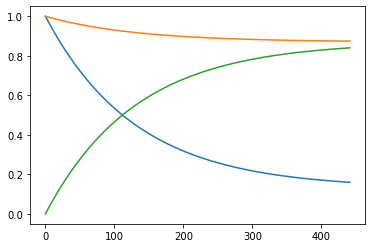

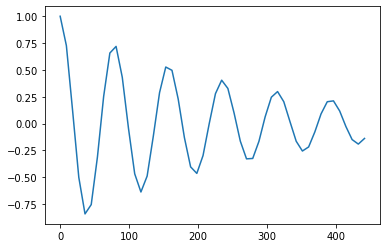

In [7]:
###############################################################################
#
# EXCITED STATE DYNAMICS: Lindblad relaxation between eigenstates
#
###############################################################################

# get (modified) redfield rate matrix
mRedRates = qr.qm.liouvillespace.rates.modifiedredfieldrates.ModifiedRedfieldRateMatrix(Hop,aggreg.sbi,aggreg.sbi.TimeAxis)
print("Modified redfield rate matrix:")
print(mRedRates.rates)


# time span of the excited state evolution (later t2 time of the 2D spectrum)
t2_axis = qr.TimeAxis(0.0, 50, 9.0)


# Lindblad relaxation operator - for detailed balanvce we need donward and upward rate
with qr.eigenbasis_of(Hop2D):
    K1 = qr.qm.ProjectionOperator(1,2,dim=Hop2D.dim)
    K2 = qr.qm.ProjectionOperator(2,1,dim=Hop2D.dim)
rates = [mRedRates.rates[1,2],mRedRates.rates[2,1]]
rates = [1/150,1/1000]

sbi = qr.qm.SystemBathInteraction(sys_operators=[K1,K2], rates=rates)

L = qr.qm.LindbladForm(Hop2D, sbi)

eUt = qr.EvolutionSuperOperator(time=t2_axis, ham=Hop2D, relt=L)
eUt.set_dense_dt(10)

with qr.eigenbasis_of(Hop2D):
    eUt.calculate()

if _show_plots_:
    with qr.eigenbasis_of(Hop2D):
        eUt.plot_element((2,2,2,2), show=False)
        eUt.plot_element((1,1,1,1), show=False)
        eUt.plot_element((1,1,2,2))
        eUt.plot_element((1,2,1,2))

In [8]:
# time axes of the propagation in t1 and t3 times
# If we don't have so fine axis we might get completely wrong shifts because of numerics - completely wrong results
t1_axis = qr.TimeAxis(0.0, 10000, 0.3)
t3_axis = qr.TimeAxis(0.0, 10000, 0.3)
rwa_cm = 16000.0

In [9]:
# Check the detailed balance:
with qr.eigenbasis_of(Hop2D):
    print(eUt.data[-1,1,1,2,2]/eUt.data[-1,2,2,1,1])
    print(rates[0]/rates[1])
    #print(eUt.data[:,2,2,2,2])

(6.66666666667+0j)
6.666666666666667


In [10]:
aggreg2D._has_egcf_matrix

True

In [11]:
from quantarhei.core.parallel import start_parallel_region, close_parallel_region

In [12]:
#aggreg2D.build(mult=2,sbi_for_higher_ex=True)

In [13]:
aggreg.diagonalize()

In [14]:
aggreg.DD

array([[[ 0.,  0.,  0.],
        [ 1.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 1.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]])

In [15]:
qr.convert(aggreg.HH,"int","1/cm")

array([[     0.        ,      0.        ,      0.        ],
       [     0.        ,  15926.51237663,      0.        ],
       [     0.        ,      0.        ,  16351.21937334]])

In [16]:
mRedRates.rates

array([[-0.,  0.,  0.],
       [ 0., -0.,  0.],
       [ 0.,  0., -0.]])

In [17]:
t2_axis.data

array([   0.,    9.,   18.,   27.,   36.,   45.,   54.,   63.,   72.,
         81.,   90.,   99.,  108.,  117.,  126.,  135.,  144.,  153.,
        162.,  171.,  180.,  189.,  198.,  207.,  216.,  225.,  234.,
        243.,  252.,  261.,  270.,  279.,  288.,  297.,  306.,  315.,
        324.,  333.,  342.,  351.,  360.,  369.,  378.,  387.,  396.,
        405.,  414.,  423.,  432.,  441.])

In [18]:
time.data

array([  0.00000000e+00,   3.00000000e-01,   6.00000000e-01, ...,
         8.99940000e+03,   8.99970000e+03,   9.00000000e+03])

In [19]:
print(t2_axis.data)
print(cfce.axis.data)

[   0.    9.   18.   27.   36.   45.   54.   63.   72.   81.   90.   99.
  108.  117.  126.  135.  144.  153.  162.  171.  180.  189.  198.  207.
  216.  225.  234.  243.  252.  261.  270.  279.  288.  297.  306.  315.
  324.  333.  342.  351.  360.  369.  378.  387.  396.  405.  414.  423.
  432.  441.]
[  0.00000000e+00   3.00000000e-01   6.00000000e-01 ...,   8.99940000e+03
   8.99970000e+03   9.00000000e+03]


In [20]:
#pcalc.system

In [21]:
# Compute absorption spectra

acalc = LinSpectrumCalculator(time,system=aggreg)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

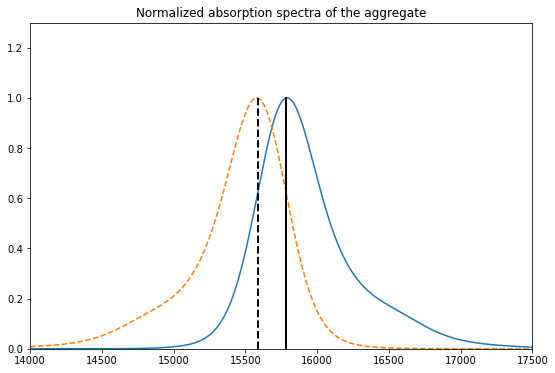

In [22]:
with qr.energy_units("1/cm"):
    plt.figure(figsize=(9,6))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.3])

In [23]:
# laboratory settings
lab = qr.LabSetup()
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)

In [24]:
aggreg2D._diagonalized
Hop.data

array([[ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  3.  ,  0.  ],
       [ 0.  ,  0.  ,  3.08]])

In [340]:
aggreg2D.HamOp.data

array([[ 0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  3.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  3.08,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  6.08]])

In [341]:
qr.convert(3.08,"int","1/cm")

16351.219373338528

In [342]:
print(aggreg2D.DD[1,3])
print(aggreg2D.DD[2,3])
print(aggreg2D.DD[0,1])
print(aggreg2D.DD[0,2])

[ 0.  0.  0.]
[ 1.  0.  0.]
[ 1.  0.  0.]
[ 0.  0.  0.]


In [343]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [344]:
qr.convert(3.0,"int","1/cm")

15926.512376628436

No handles with labels found to put in legend.


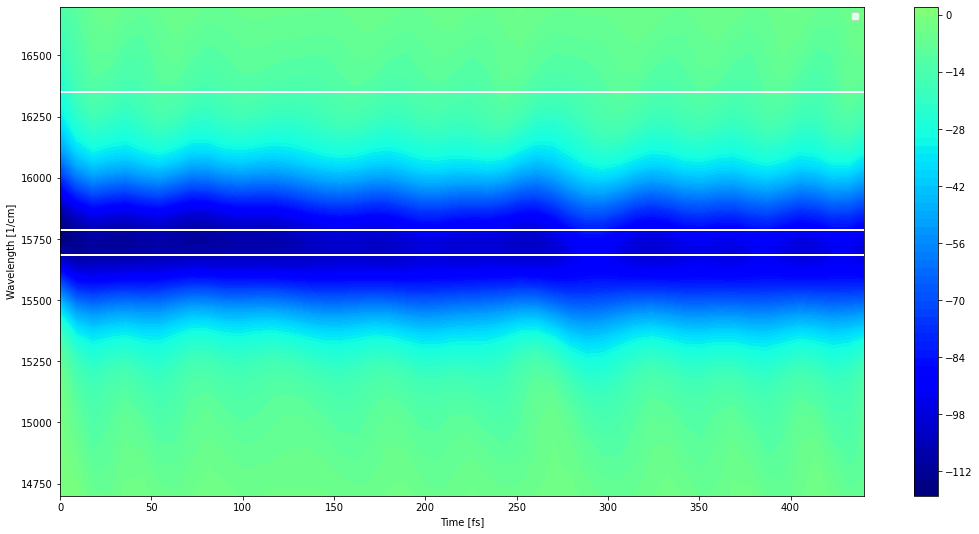

In [345]:
pcont.plot2D([[0,440],[14700,16700]],units="1/cm",zero_centered=True,lines=[15926-Lamda_vib-reorg_eng,15926-Lamda_vib,16351])

In [346]:
pp0.axis.data,pp0.data

(array([-2.22214525, -2.22109805, -2.22005085, ...,  8.24668867,
         8.24773587,  8.24878307]),
 array([ -2.43511800e-06,  -2.43549677e-06,  -2.43587532e-06, ...,
         -3.52460551e-06,  -3.52284153e-06,  -3.52107865e-06]))

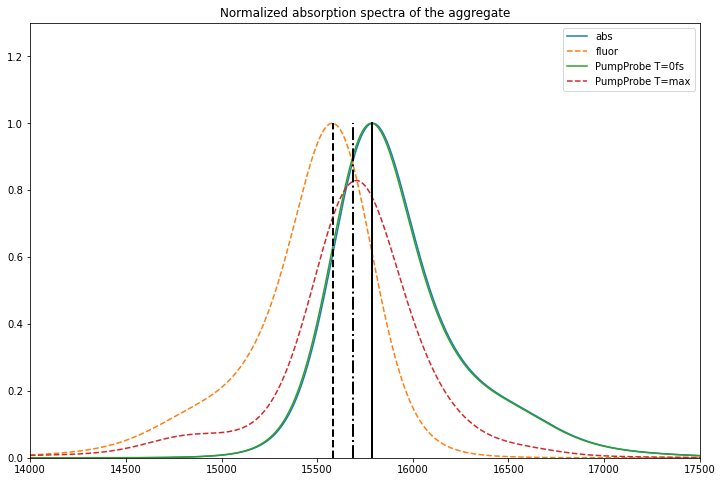

In [347]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # PP spectra at T=0 should be consistent with the absorption for the single interacting band
    # The SE at T=0 is the same as the absorption = GSB
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C2",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    # - due to the transfer part of the intensity goes to the excited state => slightly lower intensity
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C3--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.3])
    plt.legend()

In [69]:
###############################################################################
#
# PUMP-PROBE SPECTRUM: effective lineshape pump-probe spectrum
#
###############################################################################



#aggreg2D._has_egcf_matrix = False

aggreg2D.diagonalize()

# laboratory settings
# lab = qr.LabSetup()
# lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)

lab = lab_settings(lab_settings.FOUR_WAVE_MIXING)
a_0 = np.array([1.0, 0.0, 0.0], dtype=np.float64)
a_90 = np.array([0.0, 1.0, 0.0], dtype=np.float64)
a_m45 = np.array([-1.0/np.sqrt(2.0),
                     1.0/np.sqrt(2.0), 0.0], dtype=np.float64)
a_p45 = np.array([1.0/np.sqrt(2.0),
                     1.0/np.sqrt(2.0), 0.0], dtype=np.float64)
#lab.set_laser_polarizations(a_0,a_90,a_m45,a_p45)
lab.set_laser_polarizations(a_0,a_0,a_90,a_90)

t1_axis2 = qr.TimeAxis(0.0, 900, 0.5)

In [70]:
rate_matrix = np.zeros((4,4),dtype="f8")
rate_matrix[1,2] = rates[0]
rate_matrix[2,1] = rates[1]

tdcalc = qr.TwoDResponseCalculator(t1_axis2, t2_axis, t1_axis2,system=aggreg2D,rate_matrix=rate_matrix) # 

with qr.energy_units("1/cm"):
    start_parallel_region()
    tdcalc.bootstrap(rwa=rwa_cm,lab=lab,verbose=True)
    close_parallel_region()

[[ 0.          0.          0.          0.        ]
 [ 0.          0.          0.00666667  0.        ]
 [ 0.          0.001       0.          0.        ]
 [ 0.          0.          0.          0.        ]]


In [71]:
with qr.eigenbasis_of(aggreg2D.HamOp):
    tdspec = tdcalc.calculate()

t2 = 0.0fs (it2 = 0)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.53649377822876 sec
t2 = 9.0fs (it2 = 18)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.543248653411865 sec
t2 = 18.0fs (it2 = 36)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.511936902999878 sec
t2 = 27.0fs (it2 = 54)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.510383129119873 sec
t2 = 36.0fs (it2 = 72)
calculating response: 
 -

 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.518751382827759 sec
t2 = 315.0fs (it2 = 630)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.519625186920166 sec
t2 = 324.0fs (it2 = 648)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.523807764053345 sec
t2 = 333.0fs (it2 = 666)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited state absorption
 - stimulated emission with transfer
 - excited state absorption with transfer
... calculated in 4.528211355209351 sec
t2 = 342.0fs (it2 = 684)
calculating response: 
 - ground state bleach
 - stimulated emission
 - excited st

In [72]:
ppfromtd = tdspec.get_PumpProbeSpectrumContainer()

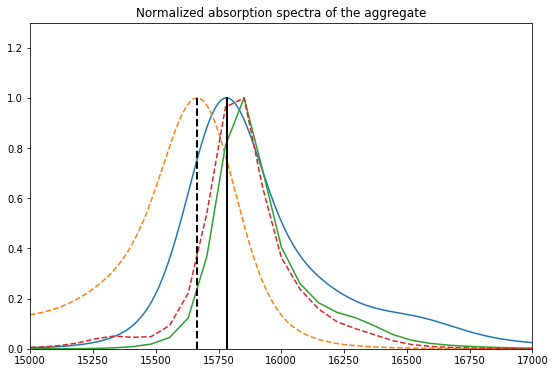

In [76]:
pp0 = ppfromtd.spectra[t2_axis.data[0]]
pp8 = ppfromtd.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(9,6))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C2",label="PumpProbe T=0fs")
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp8.data),"C3--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.xlim([15000,17000])
    plt.ylim([0.0,1.3])
    

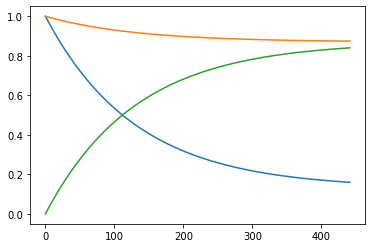

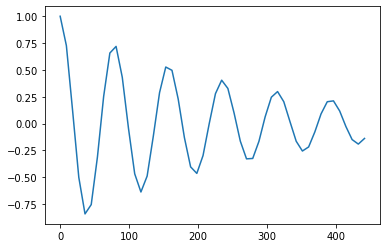

In [78]:
if _show_plots_:
    with qr.eigenbasis_of(Hop2D):
        eUt.plot_element((2,2,2,2), show=False)
        eUt.plot_element((1,1,1,1), show=False)
        eUt.plot_element((1,1,2,2))
        eUt.plot_element((1,2,1,2))

In [79]:
# laboratory settings
lab = qr.LabSetup()
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)

In [80]:
from quantarhei.qm.liouvillespace.Mockevolutionsuperoperator import MockEvolutionSuperOperator

In [81]:
Hop2D = aggreg2D.get_Hamiltonian()
eMS = MockEvolutionSuperOperator(t2_axis,Hop2D,rates=rate_matrix)
with qr.eigenbasis_of(Hop2D):
    eMS.calculate()

In [82]:
eMS.data

<bound method MockEvolutionSuperOperator.data of <quantarhei.qm.liouvillespace.Mockevolutionsuperoperator.MockEvolutionSuperOperator object at 0x2b461fc21610>>

In [83]:
pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D,rate_matrix=rate_matrix)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eMS,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


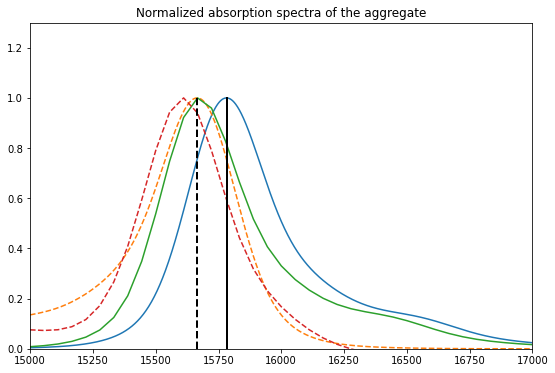

In [84]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(9,6))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C2",label="PumpProbe T=0fs")
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp8.data),"C3--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.xlim([15000,17000])
    plt.ylim([0.0,1.3])

In [ ]:
pcont.plot2D([[0,440],[15500,16500]],units="1/cm",zero_centered=False,lines=[15767,16086])

# Repeat the same with different system

In [41]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfce)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.08]])
mol2.set_dipole(0,1,[0.0,1.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfce)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
# aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)

0 -1 0 0
1 0 1 1
2 1 1 1
0 -1 0 0
1 0 1 1
2 1 1 1
3 2 2 2
2 2

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.04
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663      0.        ]
 [     0.              0.          16351.21937334]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.04
 2 : 6.08
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663      0.              0.        ]
 [     0.              0.          16351.21937334      0.        ]
 [     0.              0.              0.          32277.73174997]]


In [42]:
# laboratory settings
lab = qr.LabSetup()
lab.set_polarizations(pulse_polarizations=(Y,Y,Y), detection_polarization=Y)

In [43]:
if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [44]:
# Compute absorption spectra
acalc = LinSpectrumCalculator(time,system=aggreg)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

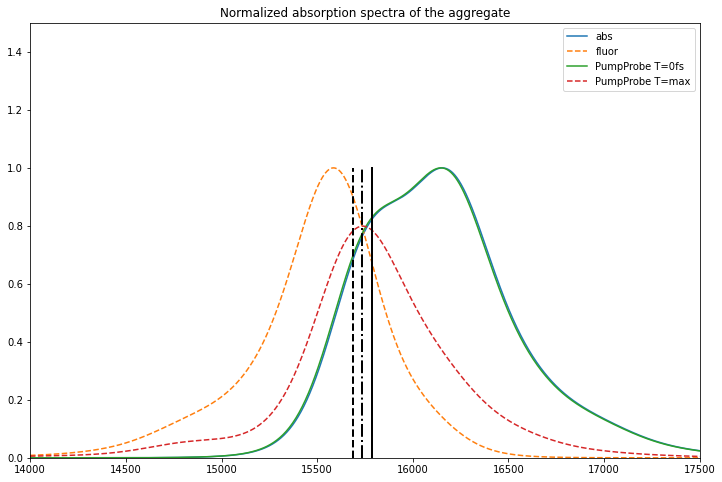

In [45]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # PP spectra at T=0 should be consistent with the absorption for the single interacting band due to the 
    # orientation averaging
    # Due to the same pump and probe polarization, at the time T=0 we should see the GSB and ESA from both states.
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C2",label="PumpProbe T=0fs")
    # For the longer waiting times T=max, when the higher state is excited and relaxes to the lower state
    # we don't see any ESA besause this state has perpendicular dipole to the higher state. When the 
    # Lower state is excited, the population still stay there and we see the ESA from this state.
    # signal at T=0 is approx GSB+ESA > at T=max signal is GSB + 1/2*ESA.
    # ESA is shifted by the bath reorganization energy
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C3--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.5])
    plt.legend()

In [46]:
# laboratory settings
lab = qr.LabSetup()
lab.set_polarizations(pulse_polarizations=(Y,Y,X), detection_polarization=X)

In [47]:
if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


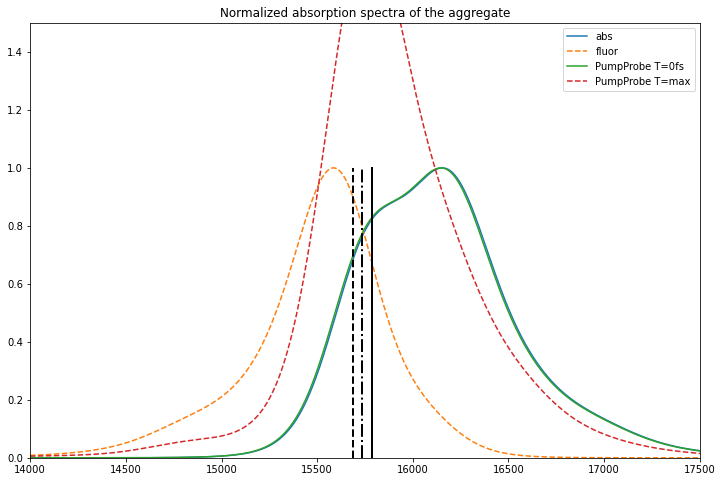

In [48]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # PP spectra at T=0 should be consistent with the absorption for the single interacting band due to the 
    # orientation averaging
    # Due to the different pump and probe polarization, at the time T=0 we should see only GSB not SE from neither 
    # of the states - because when is molecule excited in X direction only the dipoles oriented along X are
    # excited and the stimulated emission is measured in Y direction so we dont see anythig. The GSB is
    # always present because it corresponds only to the lack of the population in the ground state.
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C2",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C3--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.5])
    plt.legend()

In [49]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfce)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.08]])
mol2.set_dipole(0,1,[1.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfce)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
# aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)

0 -1 0 0
1 0 1 1
2 1 1 1
0 -1 0 0
1 0 1 1
2 1 1 1
3 2 2 2
2 2

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.04
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663      0.        ]
 [     0.              0.          16351.21937334]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.04
 2 : 6.08
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663      0.              0.        ]
 [     0.              0.          16351.21937334      0.        ]
 [     0.              0.              0.          32277.73174997]]


In [50]:
# laboratory settings
lab = qr.LabSetup()
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [51]:
# Compute absorption spectra
acalc = LinSpectrumCalculator(time,system=aggreg)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

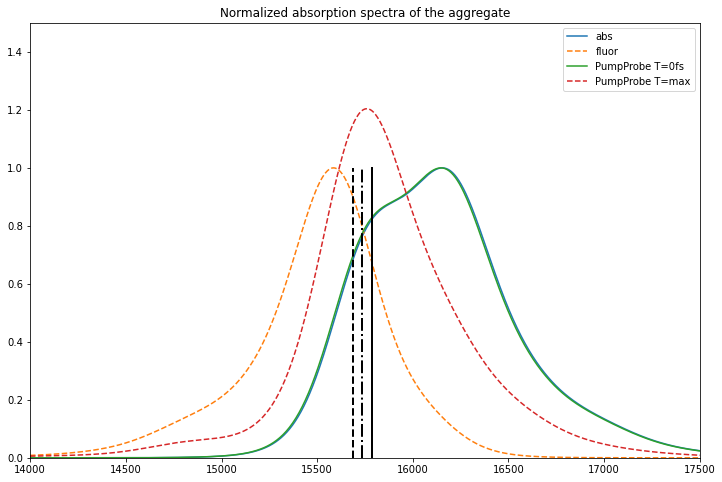

In [52]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # PP spectra at T=0 should be consistent with the absorption for the single interacting band
    # The SE at T=0 is the same as the absorption = GSB
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C2",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C3--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.5])
    plt.legend()

In [53]:
# laboratory settings
lab = qr.LabSetup()
# When the spectra are computed there is some orientation averaging - therefore with pulse polarization
# YYYY we should get the same results as with XXXX even thou the dipoles are oriented along X direction
lab.set_polarizations(pulse_polarizations=(Y,Y,Y), detection_polarization=Y)

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


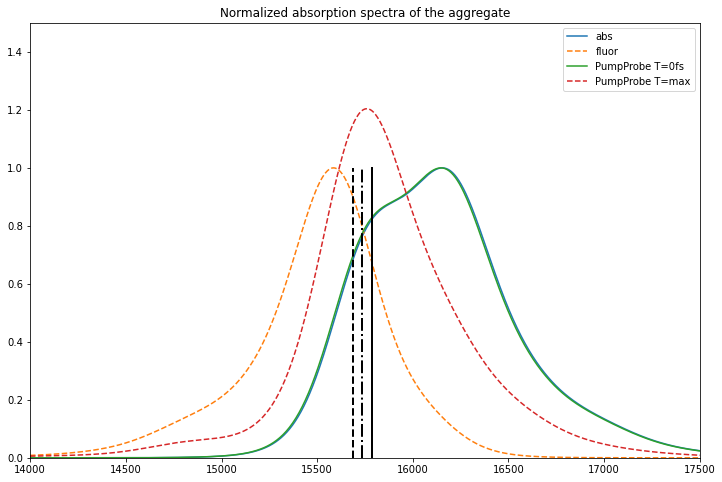

In [54]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # PP spectra at T=0 should be consistent with the absorption for the single interacting band
    # The SE at T=0 is the same as the absorption = GSB
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C2",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C3--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.5])
    plt.legend()

# Test of selective excitation by the pump pulse

In [55]:
# Define correlation function for the chlorophylls
#-----------------------------------------------------------#
time = qr.TimeAxis(0.0, 30001, 0.3) # time axis for correlation function
with qr.energy_units("1/cm"):

    # For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
    
    Temp = 300 # K
    cortime = 1/qr.convert(30,"1/cm","int")
    reorg_eng = 60 #60 37 # cm-1
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=reorg_eng,
                   cortime=cortime,  # in fs
                   T=Temp,matsubara=60) 
    cfce = qr.CorrelationFunction(time,cfce_params)

    # High frequency part of the correlation function
    nm = [[250,0.06],[300,0.04],[375,0.06],
        [500,0.04],[600,0.015],[725,0.04],[800,0.02],[875,0.02]]

    nm = np.array(nm,dtype="f8")
    omega = nm[:,0] # cm-1
    lamb = nm[:,0]*nm[:,1] #cm-1
    gamma = 5.0 #cm-1
    Lamda_vib = np.sum(lamb)


    for ii in range(nm.shape[0]):
        cfce_params2 = dict(ftype="UnderdampedBrownian",
                   reorg = lamb[ii], #reorg_vib1,
                   gamma = gamma, #gamma1,
                   freq = omega[ii], #vib1_freq,
                   T=Temp)
        cfce2 = qr.CorrelationFunction(time,cfce_params2)
        cfce.__iadd__(cfce2)

In [56]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfce)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.15]]) # 3.08
mol2.set_dipole(0,1,[1.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfce)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
# aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)

0 -1 0 0
1 0 1 1
2 1 1 1
0 -1 0 0
1 0 1 1
2 1 1 1
3 2 2 2
2 2

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.075
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663      0.        ]
 [     0.              0.          16722.83799546]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.075
 2 : 6.15
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663      0.              0.        ]
 [     0.              0.          16722.83799546      0.        ]
 [     0.              0.              0.          32649.35037209]]


In [57]:
# =============================================================================
# Define pump and probe pulse
# =============================================================================
# Definition of pump gaussian pulse
freq_pulse = time.get_FrequencyAxis()
excit_freq = mol2.elenergies[1]-qr.convert(Lamda_vib,"1/cm","int") #
pulse1 = dict(ptype="Gaussian", FWHM=0.08, amplitude=1.0, frequency = excit_freq) #FWHM=0.05

# Probe pulse treated as white light probe
pulse3 = dict(ptype="numeric",function = \
          qr.DFunction(x=freq_pulse,y=np.ones(freq_pulse.length)))

params_pulse = (pulse1, pulse1,pulse3)

# =============================================================================
# Define experimental setup
# =============================================================================
from quantarhei import LabSetup

# Define experiment setting
lab = LabSetup()
# set polarization scheme
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)
# All the pulses polarized in x direction as well as a detection polarization


# If real excitation pulse is used:
#--------------------------------------------------------
lab.set_pulse_shapes(freq_pulse, params_pulse)
# Max pulse intesity is set to one:
for ii in range(len(params_pulse)):
    max_int = np.max(lab.pulse_f[ii].data)
    lab.pulse_f[ii].data /= max_int

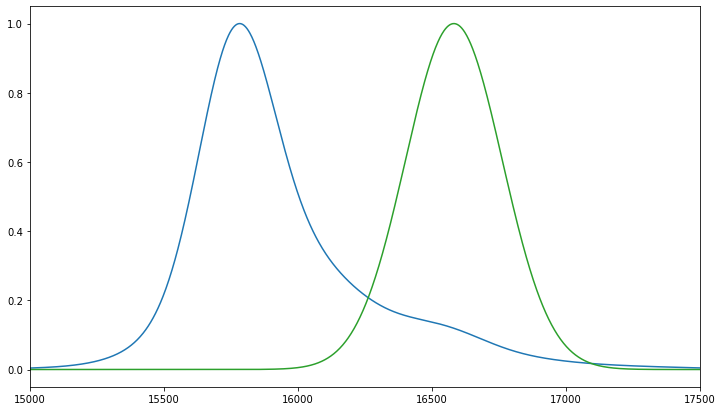

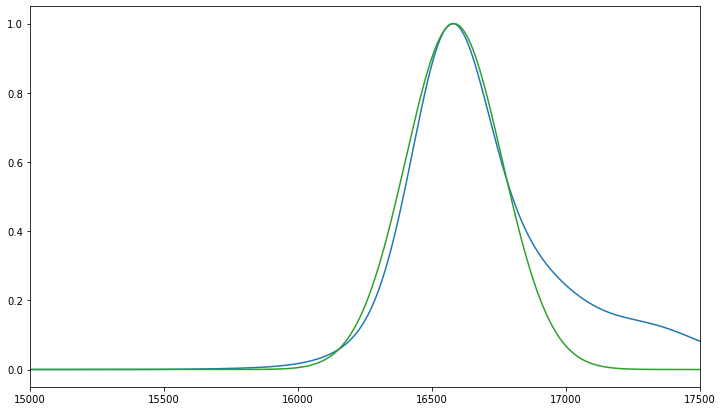

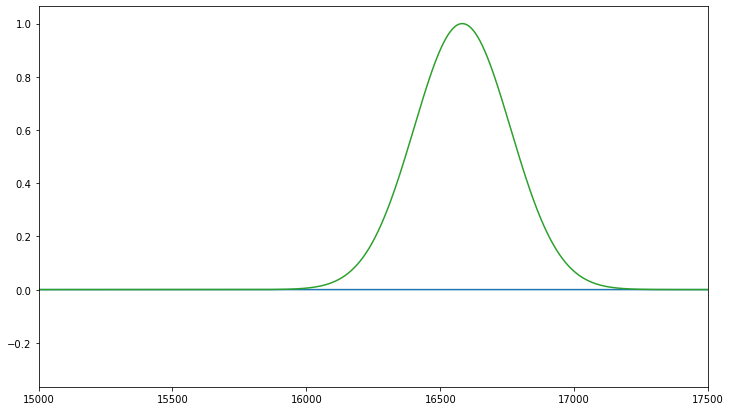

In [58]:
# compute scaling factors by spectral overlap - better than with the transition 
# energy because it can be 0-0 or vertical ...
# I'm not completely sure about this sqrt of the overlap. Because abs ~ dip**2
# then i would assume that sqrt(overlap) would correspond to dipole scaling
# and overlap*(dip**2) would correspond to the final population at that state
#
Na = aggreg2D.Ntot
scalings = np.zeros((4,Na,Na))

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

cmat = np.zeros((Na,time.length),dtype=np.complex128)
for jj in range(aggreg2D.Ntot):
    cmat[jj,:] = aggreg2D.sbi.get_coft(jj,jj)

for ii in range(1,Na): # we assume only electronic states so far
    mol = qr.Molecule(name="tmp",elenergies=[0,[aggreg2D.HH[ii,ii]]])
    mol.set_dipole(0,1,[1.0,0.0,0.0])
    
    cfce_val = np.zeros(time.length,dtype=np.complex128)
    for jj in range(aggreg2D.Ntot):
#         coft = aggreg2D.sbi.get_coft(jj,jj)
        cfce_val += (aggreg2D.SS[jj,ii]**4)*cmat[jj,:]
    cfce_params2 = dict(ftype="Value-defined",
               reorg=reorg_eng+Lamda_vib,
               cortime=cortime,  # in fs
               T=Temp,matsubara=60) 
    cfce2 = qr.CorrelationFunction(time,cfce_params2,values=cfce_val)

    mol.set_egcf((0,1),cfce2)
    
    # compute absorption
    acalc = LinSpectrumCalculator(time,system=mol)
    with qr.energy_units("1/cm"):
        acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
    spectra = acalc.calculate()
    
    with qr.energy_units("1/cm"):
        plt.figure(figsize=(12,7))
        plt.plot(spectra.axis.data,spectra.data/np.max(spectra.data),"C0-",label="abs")
        pulse = lab.pulse_f[0].at(spectra.axis.data)
        plt.plot(spectra.axis.data,pulse,"C2",label="Excitation Pulse")
        plt.xlim([15000,17500])
    
    int1 = scipy.integrate.simps(spectra.data*pulse) * spectra.axis.step
    int2 = scipy.integrate.simps(spectra.data) * spectra.axis.step
    
    scalings[0,0,ii] = int1/int2
    if scalings[0,0,ii] < 0.0:
        scalings[0,0,ii] = 0.0
    else:
        scalings[0,0,ii] = np.sqrt(scalings[0,0,ii])
        scalings[0,ii,0] = scalings[0,0,ii]
scalings[1,:,:] = scalings[0,:,:]
scalings[2,:,:] = 1.0
scalings[3,:,:] = 1.0
        
lab.dscaling = scalings.copy()
    

In [59]:
# Compute absorption spectra
acalc = LinSpectrumCalculator(time,system=aggreg)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

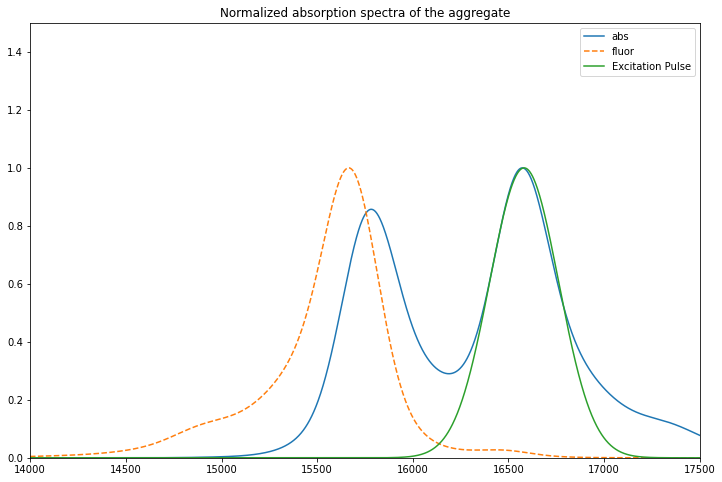

In [60]:
with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    plt.plot(lab.pulse_f[0].axis.data,lab.pulse_f[0].data,"C2",label="Excitation Pulse")
    
#     plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
#     plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
#     plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.5])
    plt.legend()

In [61]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


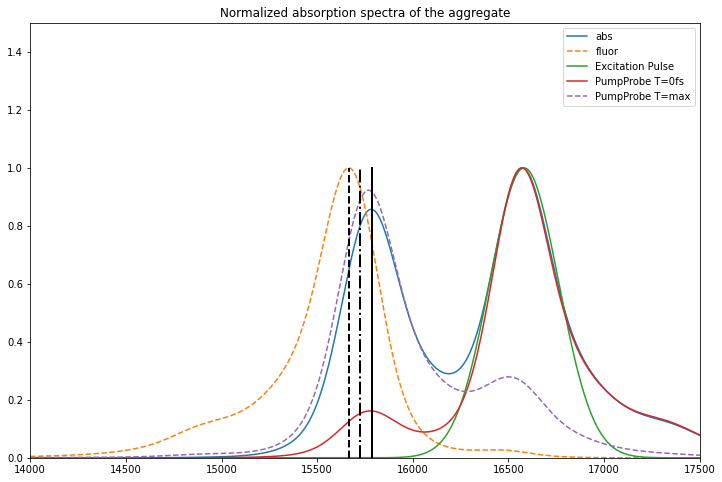

In [62]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    plt.plot(lab.pulse_f[0].axis.data,lab.pulse_f[0].data,"C2",label="Excitation Pulse")
    
    # At time T=0 the higher excited state is predominantly excited 
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C3",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C4--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.5])
    plt.legend()

In [63]:
print(scalings[0,0,1]**2/scalings[0,0,2]**2,1.0)

0.169024770592 1.0


No handles with labels found to put in legend.


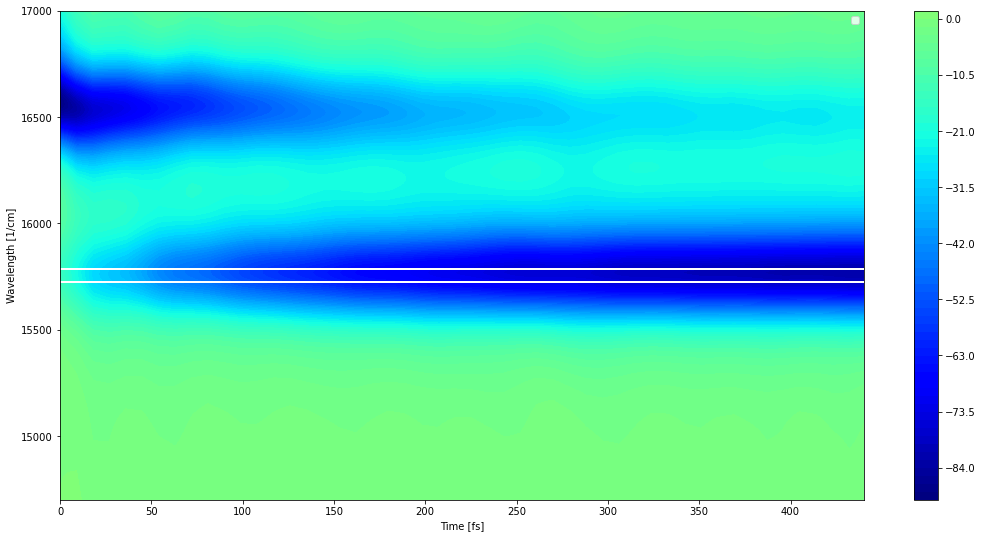

In [64]:
pcont.plot2D([[0,440],[14700,17000]],units="1/cm",zero_centered=True,lines=[15926-Lamda_vib-reorg_eng,15926-Lamda_vib])

# No coupling and no transfer

In [65]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfce)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.15]]) # 3.08
mol2.set_dipole(0,1,[1.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfce)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
# aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)

0 -1 0 0
1 0 1 1
2 1 1 1
0 -1 0 0
1 0 1 1
2 1 1 1
3 2 2 2
2 2

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.075
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663      0.        ]
 [     0.              0.          16722.83799546]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.075
 2 : 6.15
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663      0.              0.        ]
 [     0.              0.          16722.83799546      0.        ]
 [     0.              0.              0.          32649.35037209]]


In [66]:
# =============================================================================
# Define experimental setup
# =============================================================================
from quantarhei import LabSetup

# Define experiment setting
lab = LabSetup()
# set polarization scheme
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)
# All the pulses polarized in x direction as well as a detection polarization

scalings = np.zeros((4,4,4))
scalings[0,0,2] = 1.0
scalings[0,2,0] = 1.0
scalings[1,:,:] = scalings[0,:,:]
scalings[2,:,:] = 1.0
scalings[3,:,:] = 1.0

lab.dscaling = scalings.copy()

In [67]:
# Compute absorption spectra
acalc = LinSpectrumCalculator(time,system=aggreg)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

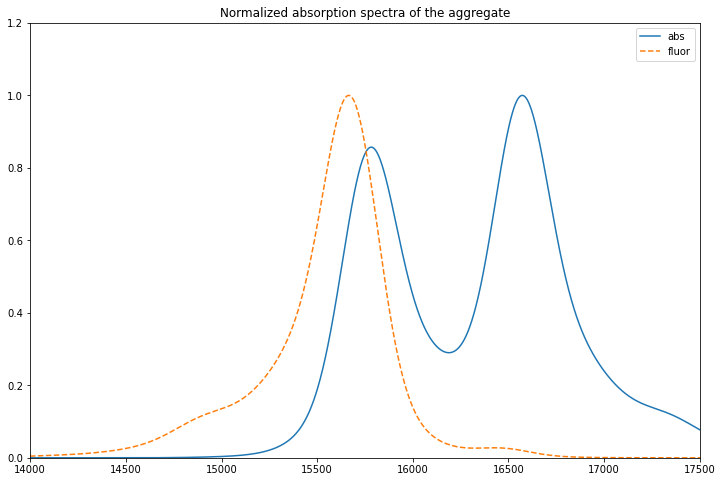

In [68]:
with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
#     plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
#     plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
#     plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.2])
    plt.legend()

Modified redfield rate matrix:
[[-0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0. -0.]]


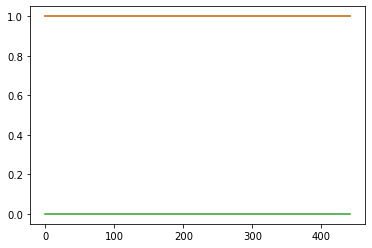

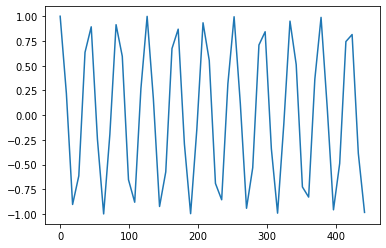

In [69]:
###############################################################################
#
# EXCITED STATE DYNAMICS: Lindblad relaxation between eigenstates
#
###############################################################################

# get (modified) redfield rate matrix
mRedRates = qr.qm.liouvillespace.rates.modifiedredfieldrates.ModifiedRedfieldRateMatrix(Hop,aggreg.sbi,aggreg.sbi.TimeAxis)
print("Modified redfield rate matrix:")
print(mRedRates.rates)


# time span of the excited state evolution (later t2 time of the 2D spectrum)
t2_axis = qr.TimeAxis(0.0, 50, 9.0)


# Lindblad relaxation operator - for detailed balanvce we need donward and upward rate
with qr.eigenbasis_of(Hop2D):
    K1 = qr.qm.ProjectionOperator(1,2,dim=Hop2D.dim)
    K2 = qr.qm.ProjectionOperator(2,1,dim=Hop2D.dim)
rates = [mRedRates.rates[1,2],mRedRates.rates[2,1]]
rates = [0.0,0.0]

sbi = qr.qm.SystemBathInteraction(sys_operators=[K1,K2], rates=rates)

L = qr.qm.LindbladForm(Hop2D, sbi)

eUt2 = qr.EvolutionSuperOperator(time=t2_axis, ham=Hop2D, relt=L)
eUt2.set_dense_dt(10)

with qr.eigenbasis_of(Hop2D):
    eUt2.calculate()

if _show_plots_:
    with qr.eigenbasis_of(Hop2D):
        eUt2.plot_element((2,2,2,2), show=False)
        eUt2.plot_element((1,1,1,1), show=False)
        eUt2.plot_element((1,1,2,2))
        eUt2.plot_element((1,2,1,2))

In [70]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt2,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


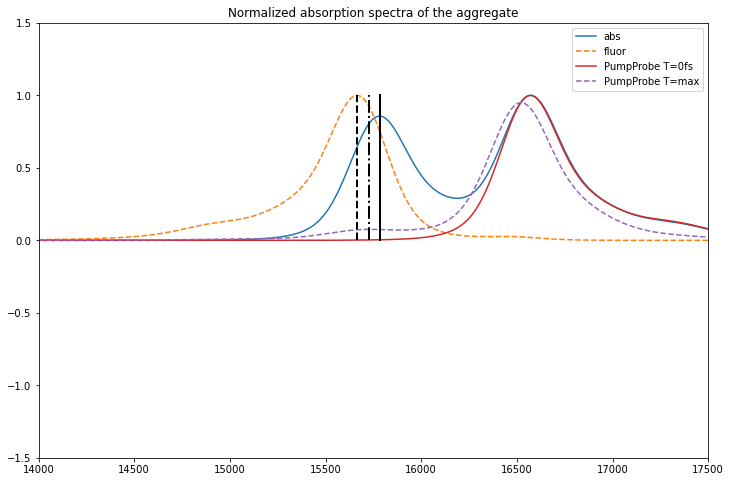

In [71]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # At time T=0 the higher excited state is predominantly excited 
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C3",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C4--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([-1.5,1.5])
    plt.legend()

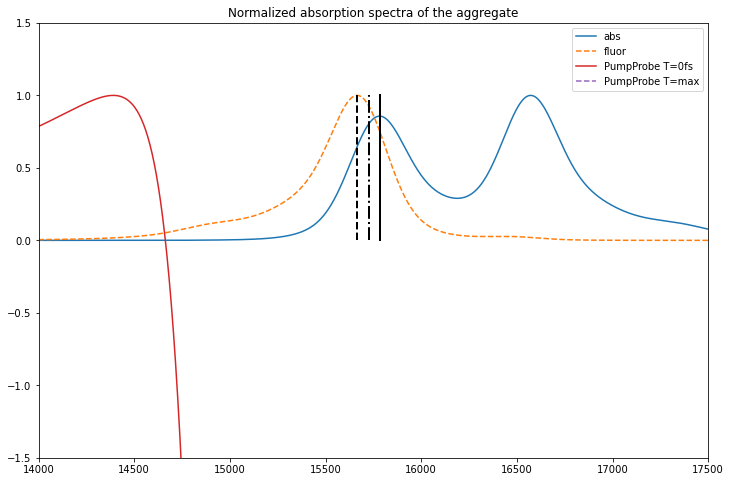

In [72]:
# pp0 = pcont.spectra[t2_axis.data[0]]
# pp8 = pcont.spectra[t2_axis.data[-1]]

# with qr.energy_units("1/cm"):
#     plt.figure(figsize=(12,8))
#     plt.title("Normalized absorption spectra of the aggregate")
#     plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
#     plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
#     # At time T=0 the higher excited state is predominantly excited 
#     plt.plot(pp0.axis.data,pp0.data/np.max(pp0.data),"C3",label="PumpProbe T=0fs")
#     # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
#     # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
#     # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
#     plt.plot(pp8.axis.data,pp8.data/np.max(pp0.data),"C4--",label="PumpProbe T=max")
    
#     plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
#     plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
#     plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
#     plt.xlim([14000,17500])
#     plt.ylim([-1.5,1.5])
#     plt.legend()

In [73]:
aggreg2D.sbi_mult

2

In [74]:
aggreg2D.sbi.CC.data


array([[  0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j, ...,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j,
          0.00000000e+00 +0.00000000e+00j],
       [  4.41522244e-03 -6.38665781e-05j,
          4.32838593e-03 -1.68589164e-04j,
          4.29336527e-03 -2.73103240e-04j, ...,
          2.41007093e-05 +2.53082217e-06j,
          2.41973663e-05 +1.68998797e-06j,
          2.42554439e-05 +8.45826738e-07j],
       [  8.83044488e-03 -1.27733156e-04j,
          8.65677186e-03 -3.37178327e-04j,
          8.58673053e-03 -5.46206481e-04j, ...,
          4.82014186e-05 +5.06164433e-06j,
          4.83947326e-05 +3.37997594e-06j,
          4.85108879e-05 +1.69165348e-06j]])

In [75]:
aggreg2D.twoex_indx

array([[0, 0],
       [0, 0],
       [0, 0],
       [1, 2]])

In [76]:
aggreg2D.sbi.CC.get_coft(0,0)

array([  4.41522244e-03 -6.38665781e-05j,
         4.32838593e-03 -1.68589164e-04j,
         4.29336527e-03 -2.73103240e-04j, ...,
         2.41007093e-05 +2.53082217e-06j,
         2.41973663e-05 +1.68998797e-06j,   2.42554439e-05 +8.45826738e-07j])

In [77]:
aggreg2D.sbi.CC.get_coft(1,1)

array([  4.41522244e-03 -6.38665781e-05j,
         4.32838593e-03 -1.68589164e-04j,
         4.29336527e-03 -2.73103240e-04j, ...,
         2.41007093e-05 +2.53082217e-06j,
         2.41973663e-05 +1.68998797e-06j,   2.42554439e-05 +8.45826738e-07j])

In [78]:
aggreg2D.sbi.CC.get_coft(2,2)

array([  8.83044488e-03 -1.27733156e-04j,
         8.65677186e-03 -3.37178327e-04j,
         8.58673053e-03 -5.46206481e-04j, ...,
         4.82014186e-05 +5.06164433e-06j,
         4.83947326e-05 +3.37997594e-06j,   4.85108879e-05 +1.69165348e-06j])

In [79]:
np.where(aggreg2D.elsigs[1]==aggreg2D.elsigs[3])

(array([], dtype=int64),)

In [80]:
1 in aggreg2D.twoex_indx[3]

True

In [81]:
# The same system but the lower peak is excited

In [82]:
# =============================================================================
# Define experimental setup
# =============================================================================
from quantarhei import LabSetup

# Define experiment setting
lab = LabSetup()
# set polarization scheme
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)
# All the pulses polarized in x direction as well as a detection polarization

scalings = np.zeros((4,4,4))
scalings[0,0,1] = 1.0
scalings[0,1,0] = 1.0
scalings[1,:,:] = scalings[0,:,:]
scalings[2,:,:] = 1.0
scalings[3,:,:] = 1.0

lab.dscaling = scalings.copy()

In [83]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt2,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


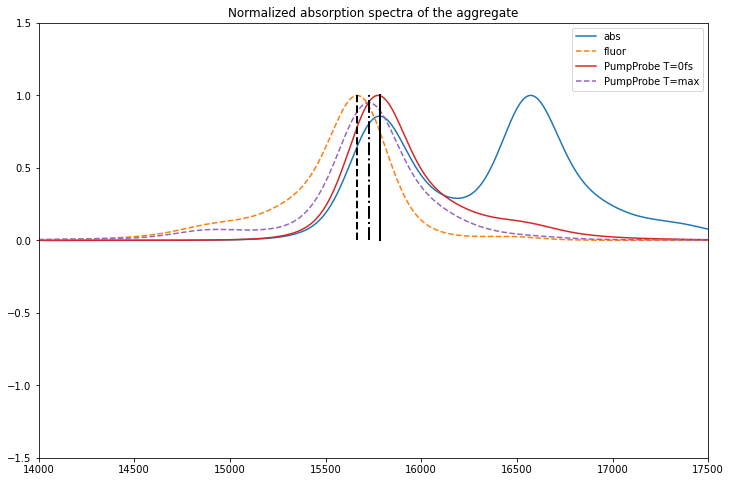

In [84]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # At time T=0 the higher excited state is predominantly excited 
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C3",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C4--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([-1.5,1.5])
    plt.legend()

# Excited higher state and transfer to the lower

In [85]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfce)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.15]]) # 3.08
mol2.set_dipole(0,1,[1.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfce)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
# aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)

0 -1 0 0
1 0 1 1
2 1 1 1
0 -1 0 0
1 0 1 1
2 1 1 1
3 2 2 2
2 2

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.075
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663      0.        ]
 [     0.              0.          16722.83799546]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.075
 2 : 6.15
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663      0.              0.        ]
 [     0.              0.          16722.83799546      0.        ]
 [     0.              0.              0.          32649.35037209]]


In [86]:
# =============================================================================
# Define experimental setup
# =============================================================================
from quantarhei import LabSetup

# Define experiment setting
lab = LabSetup()
# set polarization scheme
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)
# All the pulses polarized in x direction as well as a detection polarization

scalings = np.zeros((4,4,4))
scalings[0,0,2] = 1.0
scalings[0,2,0] = 1.0
scalings[1,:,:] = scalings[0,:,:]
scalings[2,:,:] = 1.0
scalings[3,:,:] = 1.0

lab.dscaling = scalings.copy()

Modified redfield rate matrix:
[[-0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0. -0.]]


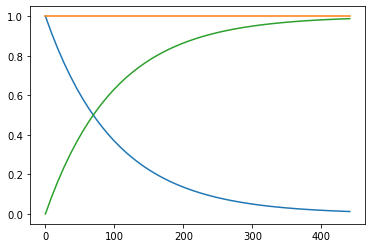

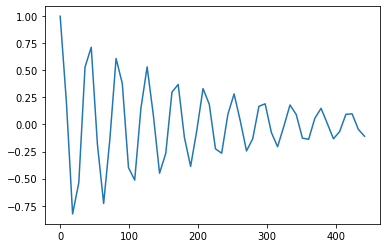

In [87]:
###############################################################################
#
# EXCITED STATE DYNAMICS: Lindblad relaxation between eigenstates
#
###############################################################################

# get (modified) redfield rate matrix
mRedRates = qr.qm.liouvillespace.rates.modifiedredfieldrates.ModifiedRedfieldRateMatrix(Hop,aggreg.sbi,aggreg.sbi.TimeAxis)
print("Modified redfield rate matrix:")
print(mRedRates.rates)


# time span of the excited state evolution (later t2 time of the 2D spectrum)
t2_axis = qr.TimeAxis(0.0, 50, 9.0)


# Lindblad relaxation operator - for detailed balanvce we need donward and upward rate
with qr.eigenbasis_of(Hop2D):
    K1 = qr.qm.ProjectionOperator(1,2,dim=Hop2D.dim)
    K2 = qr.qm.ProjectionOperator(2,1,dim=Hop2D.dim)
rates = [mRedRates.rates[1,2],mRedRates.rates[2,1]]
rates = [1/100,0.0]

sbi = qr.qm.SystemBathInteraction(sys_operators=[K1,K2], rates=rates)

L = qr.qm.LindbladForm(Hop2D, sbi)

eUt2 = qr.EvolutionSuperOperator(time=t2_axis, ham=Hop2D, relt=L)
eUt2.set_dense_dt(10)

with qr.eigenbasis_of(Hop2D):
    eUt2.calculate()

if _show_plots_:
    with qr.eigenbasis_of(Hop2D):
        eUt2.plot_element((2,2,2,2), show=False)
        eUt2.plot_element((1,1,1,1), show=False)
        eUt2.plot_element((1,1,2,2))
        eUt2.plot_element((1,2,1,2))

In [88]:
# Compute absorption spectra
acalc = LinSpectrumCalculator(time,system=aggreg)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

In [89]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt2,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


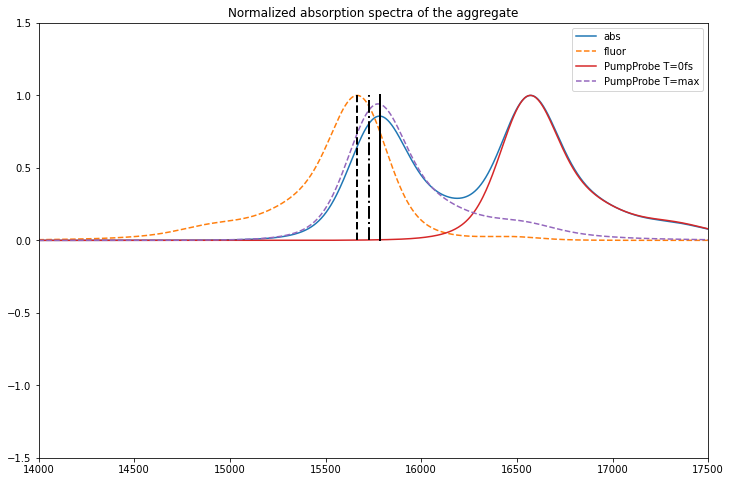

In [90]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # At time T=0 the higher excited state is predominantly excited 
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C3",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C4--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([-1.5,1.5])
    plt.legend()

No handles with labels found to put in legend.


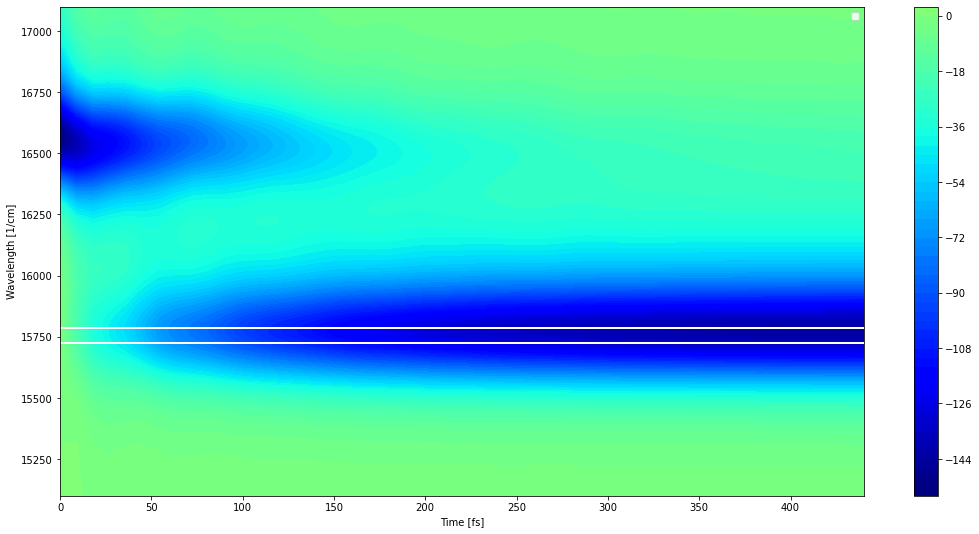

In [91]:
pcont.plot2D([[0,440],[15100,17100]],units="1/cm",zero_centered=True,lines=[15926-Lamda_vib-reorg_eng,15926-Lamda_vib])

# System with different correlation functions for each monomer

In [30]:
# -*- coding: utf-8 -*-
"""

    Calculation of pump-probe spectra


"""
import copy
import scipy
import quantarhei as qr
    
from quantarhei.spectroscopy import X,Y

from quantarhei import TwoDResponseCalculator
from aceto.lab_settings import lab_settings
from quantarhei.spectroscopy.abscalculator import LinSpectrumCalculator

from matplotlib import pyplot as plt

_show_plots_ = True
_movie_ = True


In [31]:
# Define correlation function for the chlorophylls
#-----------------------------------------------------------#
time = qr.TimeAxis(0.0, 30001, 0.3) # time axis for correlation function
with qr.energy_units("1/cm"):

    # For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
    
    Temp = 300 # K
    cortime = 1/qr.convert(30,"1/cm","int")
    reorg_eng = 100 #60 37 # cm-1
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=reorg_eng,
                   cortime=cortime,  # in fs
                   T=Temp,matsubara=60) 
    cfceA = qr.CorrelationFunction(time,cfce_params)

    # High frequency part of the correlation function
    nm = [[250,0.06],[300,0.04],[375,0.06],
        [500,0.04],[600,0.015],[725,0.04],[800,0.02],[875,0.02]]

    nm = np.array(nm,dtype="f8")
    omega = nm[:,0] # cm-1
    lamb = nm[:,0]*nm[:,1] #cm-1
    gamma = 5.0 #cm-1
    Lamda_vib = np.sum(lamb)


    for ii in range(nm.shape[0]):
        cfce_params2 = dict(ftype="UnderdampedBrownian",
                   reorg = lamb[ii], #reorg_vib1,
                   gamma = gamma, #gamma1,
                   freq = omega[ii], #vib1_freq,
                   T=Temp)
        cfce2 = qr.CorrelationFunction(time,cfce_params2)
        cfceA.__iadd__(cfce2)
        
with qr.energy_units("1/cm"):

    # For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
    
    Temp = 300 # K
    cortime = 1/qr.convert(30,"1/cm","int")
    reorg_eng = 50 #60 37 # cm-1
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=reorg_eng,
                   cortime=cortime,  # in fs
                   T=Temp,matsubara=60) 
    cfceB = qr.CorrelationFunction(time,cfce_params)


In [32]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfceB)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.15]]) # 3.08
mol2.set_dipole(0,1,[1.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfceA)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
# aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)

0 -1 0 0
1 0 1 1
2 1 1 1
0 -1 0 0
1 0 1 1
2 1 1 1
3 2 2 2
2 3

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.075
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663      0.        ]
 [     0.              0.          16722.83799546]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.075
 2 : 6.15
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663      0.              0.        ]
 [     0.              0.          16722.83799546      0.        ]
 [     0.              0.              0.          32649.35037209]]


In [33]:
# =============================================================================
# Define experimental setup
# =============================================================================
from quantarhei import LabSetup

# Define experiment setting
lab = LabSetup()
# set polarization scheme
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)
# All the pulses polarized in x direction as well as a detection polarization

# Excite the higher monomer
scalings = np.zeros((4,4,4))
scalings[0,0,2] = 1.0
scalings[0,2,0] = 1.0
scalings[1,:,:] = scalings[0,:,:]
scalings[2,:,:] = 1.0
scalings[3,:,:] = 1.0

lab.dscaling = scalings.copy()

Modified redfield rate matrix:
[[-0.  0.  0.]
 [ 0. -0.  0.]
 [ 0.  0. -0.]]


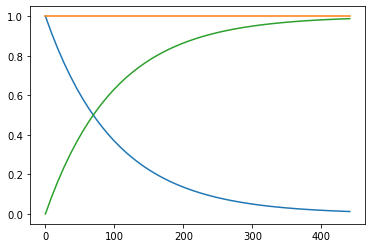

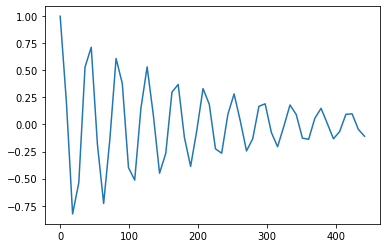

In [34]:
###############################################################################
#
# EXCITED STATE DYNAMICS: Lindblad relaxation between eigenstates
#
###############################################################################

# get (modified) redfield rate matrix
mRedRates = qr.qm.liouvillespace.rates.modifiedredfieldrates.ModifiedRedfieldRateMatrix(Hop,aggreg.sbi,aggreg.sbi.TimeAxis)
print("Modified redfield rate matrix:")
print(mRedRates.rates)


# time span of the excited state evolution (later t2 time of the 2D spectrum)
t2_axis = qr.TimeAxis(0.0, 50, 9.0)
t1_axis = qr.TimeAxis(0.0, 10000, 0.3)

# Lindblad relaxation operator - for detailed balanvce we need donward and upward rate
with qr.eigenbasis_of(Hop2D):
    K1 = qr.qm.ProjectionOperator(1,2,dim=Hop2D.dim)
    K2 = qr.qm.ProjectionOperator(2,1,dim=Hop2D.dim)
rates = [mRedRates.rates[1,2],mRedRates.rates[2,1]]
rates = [1/100.0,0.0]

sbi = qr.qm.SystemBathInteraction(sys_operators=[K1,K2], rates=rates)

L = qr.qm.LindbladForm(Hop2D, sbi)

eUt2 = qr.EvolutionSuperOperator(time=t2_axis, ham=Hop2D, relt=L)
eUt2.set_dense_dt(10)

with qr.eigenbasis_of(Hop2D):
    eUt2.calculate()

if _show_plots_:
    with qr.eigenbasis_of(Hop2D):
        eUt2.plot_element((2,2,2,2), show=False)
        eUt2.plot_element((1,1,1,1), show=False)
        eUt2.plot_element((1,1,2,2))
        eUt2.plot_element((1,2,1,2))

In [35]:
# Compute absorption spectra
rwa_cm = 16000
acalc = LinSpectrumCalculator(time,system=aggreg)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

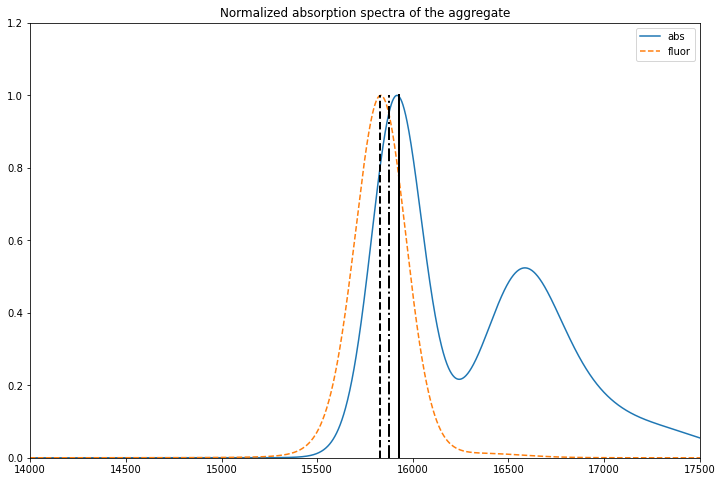

In [36]:
with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    plt.plot([15926,15926],[0,1.0],"k",linewidth=2)
    plt.plot([15926-2*50,15926-2*50],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-50,15926-50],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.2])
    plt.legend()

In [37]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt2,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


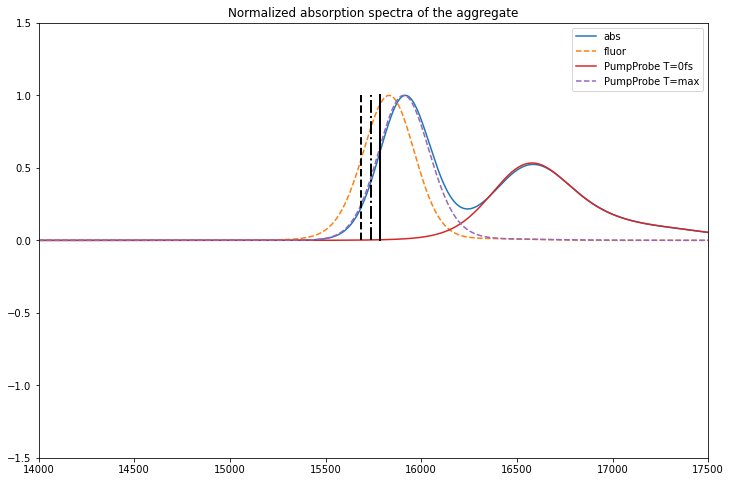

In [40]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # At time T=0 the higher excited state is predominantly excited 
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp8.data),"C3",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp8.data),"C4--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([-1.5,1.5])
    plt.legend()

# Coupled system with modified redfield rates (higher state excited)

In [16]:
# -*- coding: utf-8 -*-

"""

    Calculation of pump-probe spectra


"""
import copy
import scipy
import quantarhei as qr
    
from quantarhei.spectroscopy import X,Y

from quantarhei import TwoDResponseCalculator
from aceto.lab_settings import lab_settings
from quantarhei.spectroscopy.abscalculator import LinSpectrumCalculator

from matplotlib import pyplot as plt

_show_plots_ = True
_movie_ = True


In [17]:
# Define correlation function for the chlorophylls
#-----------------------------------------------------------#
time = qr.TimeAxis(0.0, 30001, 0.3) # time axis for correlation function
with qr.energy_units("1/cm"):

    # For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
    
    Temp = 300 # K
    cortime = 1/qr.convert(30,"1/cm","int")
    reorg_eng = 100 #60 37 # cm-1
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=reorg_eng,
                   cortime=cortime,  # in fs
                   T=Temp,matsubara=60) 
    cfceA = qr.CorrelationFunction(time,cfce_params)

    # High frequency part of the correlation function
    nm = [[250,0.06],[300,0.04],[375,0.06],
        [500,0.04],[600,0.015],[725,0.04],[800,0.02],[875,0.02]]

    nm = np.array(nm,dtype="f8")
    omega = nm[:,0] # cm-1
    lamb = nm[:,0]*nm[:,1] #cm-1
    gamma = 5.0 #cm-1
    Lamda_vib = np.sum(lamb)


    for ii in range(nm.shape[0]):
        cfce_params2 = dict(ftype="UnderdampedBrownian",
                   reorg = lamb[ii], #reorg_vib1,
                   gamma = gamma, #gamma1,
                   freq = omega[ii], #vib1_freq,
                   T=Temp)
        cfce2 = qr.CorrelationFunction(time,cfce_params2)
        cfceA.__iadd__(cfce2)
        
with qr.energy_units("1/cm"):

    # For better precision in redfield rates we need larger time axis with the same dt -> smaller dw in the freq axis
    
    Temp = 300 # K
    cortime = 1/qr.convert(30,"1/cm","int")
    reorg_eng = 50 #60 37 # cm-1
    cfce_params = dict(ftype="OverdampedBrownian",
                   reorg=reorg_eng,
                   cortime=cortime,  # in fs
                   T=Temp,matsubara=60) 
    cfceB = qr.CorrelationFunction(time,cfce_params)


In [18]:
###############################################################################
#
# MODEL: Simple dimer of molecules
#
###############################################################################

# Define simple system of interacting identical molecules
#-----------------------------------------------------------#
mol1 = qr.Molecule(name="Molecule1",elenergies=[0,[3.0]])
mol1.set_dipole(0,1,[1.0,0.0,0.0])
mol1._position = [0.0,0.0,0.0]
mol1.set_egcf((0,1),cfceB)
mol1.set_transition_width((0,1),10.0)

mol2 = qr.Molecule(name="Molecule2",elenergies=[0,[3.15]]) # 3.08
mol2.set_dipole(0,1,[1.0,0.0,0.0])
mol2._position = [10.0,0.0,0.0]
mol2.set_egcf((0,1),cfceA)
mol2.set_transition_width((0,1),5.0)

aggreg = qr.Aggregate()
aggreg.add_Molecule(mol1)
aggreg.add_Molecule(mol2)
aggreg.set_resonance_coupling(0,1,0.1)

aggreg2D = copy.copy(aggreg)

aggreg.build(mult=1,sbi_for_higher_ex=False)
aggreg2D.build(mult=2,sbi_for_higher_ex=True)

# we print its Hamiltonian to check everything is alright
Hop = aggreg.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop)

Hop2D = aggreg2D.get_Hamiltonian()
with qr.energy_units("1/cm"):
    print(Hop2D)


quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 2
Block average energies:
 0 : 0.0
 1 : 3.075
data = 
[[     0.              0.              0.        ]
 [     0.          15926.51237663    530.88374589]
 [     0.            530.88374589  16722.83799546]]

quantarhei.Hamiltonian object
units of energy 1/cm
Rotating Wave Approximation (RWA) enabled : True
Number of blocks : 3
Block average energies:
 0 : 0.0
 1 : 3.075
 2 : 6.15
data = 
[[     0.              0.              0.              0.        ]
 [     0.          15926.51237663    530.88374589      0.        ]
 [     0.            530.88374589  16722.83799546      0.        ]
 [     0.              0.              0.          32649.35037209]]


In [19]:
# =============================================================================
# Define pump and probe pulse
# =============================================================================
# Definition of pump gaussian pulse
freq_pulse = time.get_FrequencyAxis()

eng,val = np.linalg.eigh(aggreg2D.HamOp.data)

excit_freq = eng[2]-qr.convert(Lamda_vib*0.8,"1/cm","int") #
pulse1 = dict(ptype="Gaussian", FWHM=0.08, amplitude=1.0, frequency = excit_freq) #FWHM=0.05

# Probe pulse treated as white light probe
pulse3 = dict(ptype="numeric",function = \
          qr.DFunction(x=freq_pulse,y=np.ones(freq_pulse.length)))

params_pulse = (pulse1, pulse1,pulse3)

# =============================================================================
# Define experimental setup
# =============================================================================
from quantarhei import LabSetup

# Define experiment setting
lab = LabSetup()
# set polarization scheme
lab.set_polarizations(pulse_polarizations=(X,X,X), detection_polarization=X)
# All the pulses polarized in x direction as well as a detection polarization


# If real excitation pulse is used:
#--------------------------------------------------------
lab.set_pulse_shapes(freq_pulse, params_pulse)
# Max pulse intesity is set to one:
for ii in range(len(params_pulse)):
    max_int = np.max(lab.pulse_f[ii].data)
    lab.pulse_f[ii].data /= max_int

In [20]:
# Compute absorption spectra
rwa_cm = 16000
acalc = LinSpectrumCalculator(time,system=aggreg2D)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

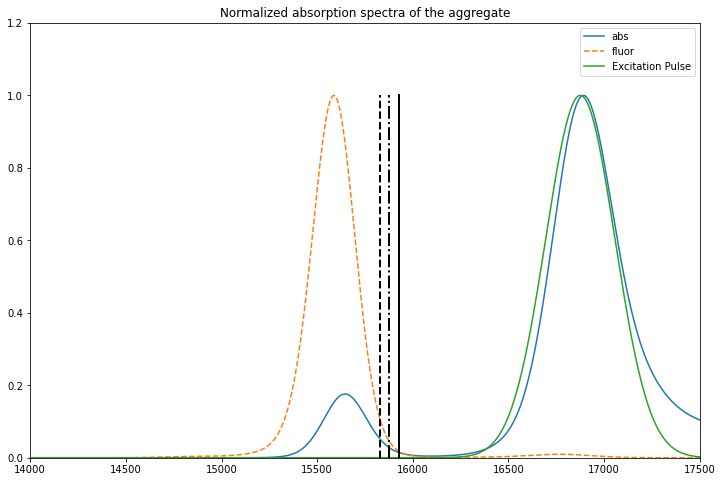

In [21]:
with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    plt.plot(lab.pulse_f[0].axis.data,lab.pulse_f[0].data,"C2",label="Excitation Pulse")
    
    plt.plot([15926,15926],[0,1.0],"k",linewidth=2)
    plt.plot([15926-2*50,15926-2*50],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-50,15926-50],[0,1.0],"k-.",linewidth=2)
    plt.xlim([14000,17500])
    plt.ylim([0.0,1.2])
    plt.legend()

In [22]:
scalings = np.zeros((4,4,4))
scalings[0,0,2] = 1.0
scalings[0,2,0] = 1.0
scalings[1,:,:] = scalings[0,:,:]
scalings[2,:,:] = 1.0
scalings[3,:,:] = 1.0

lab.dscaling = scalings.copy()

In [23]:
# Compute absorption spectra
rwa_cm = 16000
acalc = LinSpectrumCalculator(time,system=aggreg2D)
with qr.energy_units("1/cm"):
    acalc.bootstrap(rwa=rwa_cm) #,HWHH=100.0 If HWHH specified also spectra with gaussian peak is calculated
spectra = acalc.calculate()

Modified redfield rate matrix:
[[ -0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -3.15161379e-05   1.05732353e-02]
 [  0.00000000e+00   3.15161379e-05  -1.05732353e-02]]


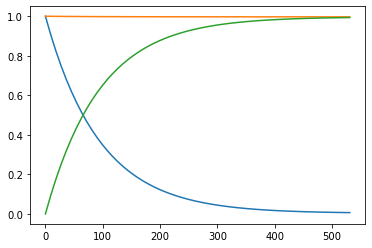

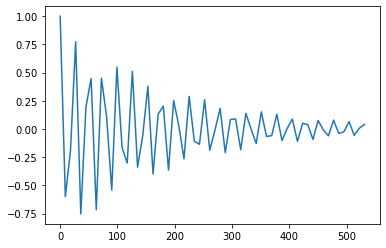

In [24]:
###############################################################################
#
# EXCITED STATE DYNAMICS: Lindblad relaxation between eigenstates
#
###############################################################################

# get (modified) redfield rate matrix
mRedRates = qr.qm.liouvillespace.rates.modifiedredfieldrates.ModifiedRedfieldRateMatrix(Hop,aggreg.sbi,aggreg.sbi.TimeAxis)
print("Modified redfield rate matrix:")
print(mRedRates.rates)


# time span of the excited state evolution (later t2 time of the 2D spectrum)
t2_axis = qr.TimeAxis(0.0, 60, 9.0)
t1_axis = qr.TimeAxis(0.0, 10000, 0.3)

# Lindblad relaxation operator - for detailed balanvce we need donward and upward rate
with qr.eigenbasis_of(Hop2D):
    K1 = qr.qm.ProjectionOperator(1,2,dim=Hop2D.dim)
    K2 = qr.qm.ProjectionOperator(2,1,dim=Hop2D.dim)
rates = [mRedRates.rates[1,2],mRedRates.rates[2,1]]
#rates = [1/100.0,0.0]

sbi = qr.qm.SystemBathInteraction(sys_operators=[K1,K2], rates=rates)

L = qr.qm.LindbladForm(Hop2D, sbi)

eUt2 = qr.EvolutionSuperOperator(time=t2_axis, ham=Hop2D, relt=L)
eUt2.set_dense_dt(10)

with qr.eigenbasis_of(Hop2D):
    eUt2.calculate()

if _show_plots_:
    with qr.eigenbasis_of(Hop2D):
        eUt2.plot_element((2,2,2,2), show=False)
        eUt2.plot_element((1,1,1,1), show=False)
        eUt2.plot_element((1,1,2,2))
        eUt2.plot_element((1,2,1,2))

In [25]:
from quantarhei.spectroscopy.pumpprobe2 import PumpProbeSpectrumCalculator

if not aggreg2D._diagonalized:
    aggreg2D.diagonalize()

pcalc = PumpProbeSpectrumCalculator(t2_axis,t1_axis,system=aggreg2D)
with qr.energy_units("1/cm"):
    pcalc.bootstrap(rwa=rwa_cm)

with qr.eigenbasis_of(aggreg2D.HamOp):
    pcont = pcalc.calculate_all_system(aggreg2D,eUt2,lab)

     - Progress: |██████████████████████████████████████████████████| 100.0% Complete


In [26]:
print(-4.58746491e-06/1.78632838e-06)
print(-7.33502662e+01/-2.23288463e+01)

-2.5680971994634043
3.2850002733907484


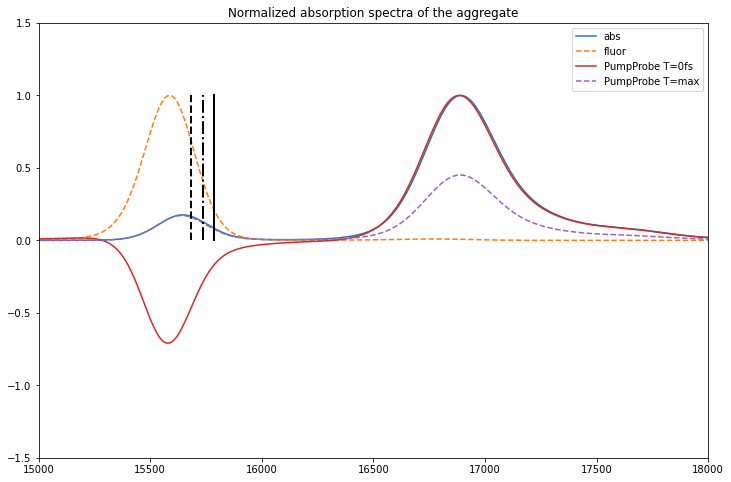

In [27]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # At time T=0 the higher excited state is predominantly excited 
    plt.plot(pp0.axis.data,-pp0.data/np.max(-pp0.data),"C3",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,-pp8.data/np.max(-pp0.data),"C4--",label="PumpProbe T=max")
    
    plt.plot([15926-Lamda_vib,15926-Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15926-Lamda_vib-2*reorg_eng,15926-Lamda_vib-2*reorg_eng],[0,1.0],"k--",linewidth=2)
    plt.plot([15926-Lamda_vib-reorg_eng,15926-Lamda_vib-reorg_eng],[0,1.0],"k-.",linewidth=2)
    plt.xlim([15000,18000])
    plt.ylim([-1.5,1.5])
    plt.legend()

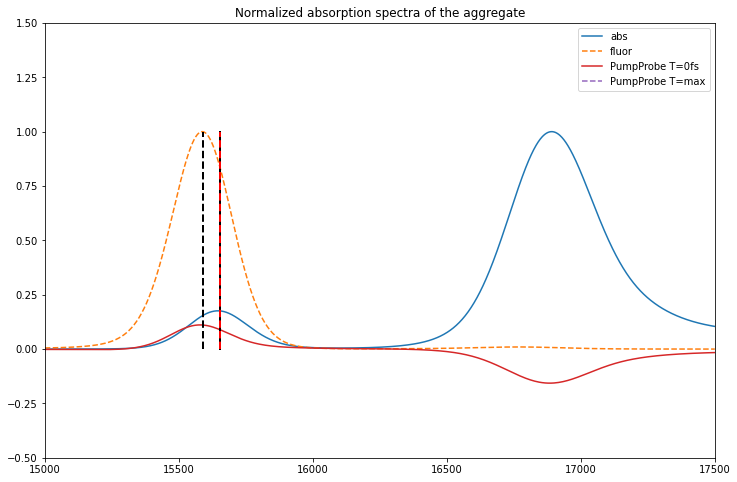

In [28]:
pp0 = pcont.spectra[t2_axis.data[0]]
pp8 = pcont.spectra[t2_axis.data[-1]]

SS = aggreg2D.SS

with qr.energy_units("1/cm"):
    plt.figure(figsize=(12,8))
    plt.title("Normalized absorption spectra of the aggregate")
    plt.plot(spectra["abs"].axis.data,spectra["abs"].data/np.max(spectra["abs"].data),"C0-",label="abs")
    plt.plot(spectra["fluor"].axis.data,spectra["fluor"].data/np.max(spectra["fluor"].data),"C1--",label="fluor")
    
    # At time T=0 the higher excited state is predominantly excited 
    plt.plot(pp0.axis.data,pp0.data*(0.4472136/1.34164079)**2/np.max(pp0.data),"C3",label="PumpProbe T=0fs")
    # For the longer waiting times the bath has time to relax and SE is shifted by 2 reorg energy 
    # and has a shape of the fluorescence spectra. The GSB contribution is still only the absorption.
    # The complete contribution is therefore absorption + fluorescence => shift only by 1 reorg energy.
    plt.plot(pp8.axis.data,pp8.data/np.max(pp8.data),"C4--",label="PumpProbe T=max")
    
    plt.plot([15661-(SS[2,1]**4)*Lamda_vib,15661-(SS[2,1]**4)*Lamda_vib],[0,1.0],"k",linewidth=2)
    plt.plot([15661-(SS[2,1]**4)*Lamda_vib-2*(SS[1,1]**4)*50,15661-(SS[2,1]**4)*Lamda_vib-2*(SS[1,1]**4)*50],[0,1.0],"k--",linewidth=2)
    plt.plot([15661-(1-SS[2,2]**2)**2*Lamda_vib,15661-(1-SS[2,2]**2)**2*Lamda_vib],[0,1.0],"r--",linewidth=2)
    plt.xlim([15000,17500])
    plt.ylim([-0.5,1.5])
    plt.legend()

In [29]:
(SS[2,1]**4)*100

4.0000000000000036

In [30]:
aggreg2D.DD[0,2,0]

1.3416407864998738

In [31]:
aggreg2D.DD[2,3,0]

1.3416407864998738

In [32]:
print(aggreg2D.HH)

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.95000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.22044605e-16   3.20000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00   6.15000000e+00]]


In [33]:
qr.convert(2.95000000,"int","1/cm")

15661.070503684628

No handles with labels found to put in legend.


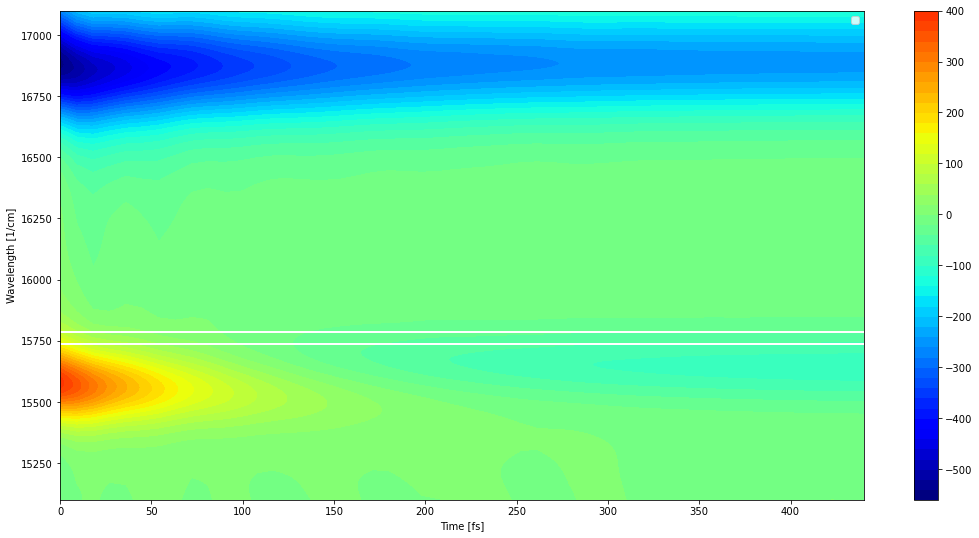

In [34]:
pcont.plot2D([[0,440],[15100,17100]],units="1/cm",zero_centered=True,lines=[15926-Lamda_vib-reorg_eng,15926-Lamda_vib])